# Titanic

## Data Exploration

In [1]:
# import module and train/test set
import numpy as np
import pandas as pd

# Control warning error output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# combine the train set and predict set to simplify the step
# 处理缺失数据等步骤, 统一进行处理令操作简洁
full=pd.concat([train,test],ignore_index=True)

In [3]:
# 查看数据集样本示例
full.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282


In [4]:
# 统计所给数据信息，包括每个属性的类型（字符，布尔或者是数值类型），以及每个属性是否缺失数据
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
# 查看数据集统计信息
# full.describe()

## Feature Engineering

### 缺失值插补

观察到数据集中样本的某些特征值缺失, 如果后续选用这些特征的话, 需将其补全.

- #### 补全 Age 信息

In [6]:
# fill the missing 'Age' according to their 'Title'
full['Title']=full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
nn={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}

full.Title=full.Title.map(nn)

# assign the female 'Dr' to 'Rarewoman'
full.loc[full.PassengerId==797,'Title']='Rarewoman'
full.Age.fillna(999,inplace=True)
def girl(aa):
    if (aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif (aa.Age==999)&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title

full['Title']=full.apply(girl,axis=1)

Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    full.loc[(full.Age==999)&(full.Title==i),'Age']=full.loc[full.Title==i,'Age'].median()

In [7]:
# 均值填充缺失的 Age
# full['Age'] = full['Age'].fillna(titanic['Age'].median())

### 标准化（Standardization）

数据的标准化是将数据按比例缩放，使之落入一个小的特定区间.

各属性值之间 scale 差距太大，会影响收敛速度, 甚至不收敛.

因此，需要对连续型属性归一化，让它们在[-1，1]之间.

区别于 **归一化（Normalization)**

- 把数据变为（0，1）之间的小数
- 把有量纲表达式变换为无量纲表达式，成为纯量

> 归一化是为了消除不同数据之间的量纲，方便数据比较和共同处理，比如在神经网络中，归一化可以加快训练网络的收敛性.

- #### 标准化 Age

In [8]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(full['Age'].values.reshape(-1, 1))
full['Age'] = age_scale_param.transform(full['Age'].values.reshape(-1, 1))

### 把 字符型特征 转换成 数值型 的, 便于算法进行处理

逐个将需要转化的特征进行数值化处理:

In [9]:
# 查看数据集中 Sex 的类别
print(full['Sex'].unique())

# replace all the occurences of male with the number 0
full.loc[full['Sex']=='male', 'Sex'] = 0
full.loc[full['Sex']=='female', 'Sex'] = 1

['male' 'female']


统一数值化处理:

In [10]:
# convert categorical variables to numerical variables
# predictors=['Pclass', 'Sex', 'Age']
# full_dummies=pd.get_dummies(full[predictors])

## select features to use

### 特征组合

Pandas 提供的功能特性可直接将不同特征组合在一起.

In [11]:
# generate a familysize column
# full['family_size'] = full['SibSp'] + full['Parch']

# the .apply method generates a new series
# full['name_length'] = full['Name'].apply(lambda x:len(x))

### 找到重要特征

控制变量 + 加噪声, 得分前后对比, 从而找出重要的特征.

In [12]:
# setting the selected features together makes steps fewer
predictors=['Pclass', 'Sex', 'Age']

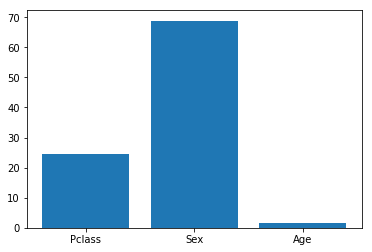

In [15]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

train_new = full[:891]

# perform feature selection
# k：选择的特征的个数
selector = SelectKBest(f_classif, k=3)
selector.fit(train_new[predictors], train_new['Survived'])

# get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# plot the scores
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors)
plt.show()

In [16]:
# pick the important features
predictors=['Pclass', 'Sex', 'Age']

- #### 数值类型转换

In [17]:
# train['Survived'][:890].astype(np.int64)

## Model Building

- #### 划分 训练集 与 测试集

In [18]:
# separate the processed set into train_set, train_target, predict_set
X=full[predictors][:891]
y=full.Survived[:891]
test_X=full[predictors][891:]

In [19]:
# Logistic Regression model -0.7889 -0.7946
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C= 0.1)

# Random Forest model -0.7957 -0.8115
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3, n_estimators=500)

# SVM model - 0.7946 -0.8136
from sklearn.svm import SVC, LinearSVC
svc = SVC(C=0.88, gamma=0.8, probability=True)

# KNN model -0.8081 -worse
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# decision tree -0.8081 -worse
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=3)

# GradientBoosting model -0.8047 -0.8081
from sklearn.ensemble import GradientBoostingClassifier
gb =GradientBoostingClassifier(random_state=3, learning_rate=0.003, max_depth=20, n_estimators=500)

# XgBoost model -0.8069 -0.8249
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500,max_depth=6,learning_rate=0.03)

# adaboost -0.7845 -0.7900
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=3,n_estimators=500,learning_rate=0.01)

### 通过网格搜索确定最佳效果参数

GridSearchCV 用于系统地遍历多种参数组合, 自动调参，只要把参数输进去，就能给出最优化的结果和参数.

但是这个方法适合于小数据集，一旦数据的量级上去了，很难得出结果.

数据量比较大的时候可以使用一个快速调优的方法 —— 坐标下降.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':range(10,71,10)}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1,cv=5,verbose=1)
grid_search.fit(X,y)
grid_search.best_params_, grid_search.best_score_

## Ensemble Learning

In [20]:
# use VotingClassifier to ensemble the previous training classifier
from sklearn.ensemble import VotingClassifier

eclf_soft = VotingClassifier(estimators=[('LR',lr),('RF',rf),('GDBT',gb),('SVM',svc),('KNN',knn),('D_Tree',dt),('ADAB',ada)],voting='soft')

# add weights
eclfW_soft = VotingClassifier(estimators=[('LR',lr),('RF',rf),('GDBT',gb),('SVM',svc),('KNN',knn),('D_Tree',dt),('ADAB',ada)],voting='soft',weights=[1,1,1,1,1,1,1])

eclfW_soft.fit(X, y)

VotingClassifier(estimators=[('LR', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('RF', RandomF...hm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=500, random_state=3))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1, 1, 1, 1, 1])

## learning curve

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用 sklearn 的 learning_curve 得到 training_score 和 cv_score，使用 matplotlib 画出 learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=4,
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("number of train set samples")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="score of train set")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="score of CV")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(eclfW_soft, "learning curve", X, y)

## Correct rate

In [ ]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(eclfW_soft, X, y, cv=5, verbose=1)
print(scores.mean())

## Predict

In [ ]:
# use the final model to predict the given test set file,
# make the specific format of the data stored in csv
prediction = eclfW_soft.predict(test_X)

### write to csv

In [ ]:
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': prediction.astype(np.int32)})
result.to_csv("./ensemble_result.csv", index=False)